In [1]:
#Creating a generator to generate new mnist_fashion images


#downloading data
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
(x_train,y_train), (x_test,y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [2]:
import numpy as np
#merge training and testing data set
dataset = np.concatenate([x_train,x_test],axis=0)
#reshape data to [0,1]
dataset = np.expand_dims(dataset,-1).astype("float32")/255
batch_size = 64
dataset = np.reshape(dataset,(-1,28,28,1))

dataset = tf.data.Dataset.from_tensor_slices(dataset)

dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
noise_dim=150

generator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(noise_dim,)),
    layers.Dense(7*7*256),
    layers.Reshape(target_shape=(7,7,256)),
    layers.Conv2DTranspose(256,3,activation="LeakyReLU",strides=2,padding="same"),
    layers.Conv2DTranspose(128,3,activation="LeakyReLU",strides=2,padding="same"),
    layers.Conv2DTranspose(1,3,activation="sigmoid",padding="same"),
])
generator.summary()
discriminator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(28,28,1)),
    layers.Conv2D(256,3,activation="relu",strides=2,padding="same"),
    layers.Conv2D(128,3,activation="relu",strides=2,padding="same"),
    layers.Flatten(),
    layers.Dense(64,activation= "relu"),
    layers.Dropout(0.2),
    layers.Dense(1,activation="sigmoid")
])
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1894144   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 256)       590080    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 128)       295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         1153      
 Transpose)                                                      
                                                        

In [4]:
optimizerG= keras.optimizers.Adam(learning_rate =0.00001, beta_1=0.5)
optimizerD= keras.optimizers.Adam(learning_rate =0.00003, beta_1=0.5)

lossFn = tf.losses.BinaryCrossentropy(from_logits=True)
gAccMetric = tf.keras.metrics.BinaryAccuracy()
dAccMetric = tf.keras.metrics.BinaryAccuracy()

In [5]:
@tf.function
def trainDstep(data):
    batch_size = tf.shape(data)[0]

    noise = tf.random.normal(shape = (batch_size,noise_dim))
    y_true = tf.concat(
    [tf.ones(batch_size,1),
    tf.zeros(batch_size,1)],axis=0)

    with tf.GradientTape() as tape:
        fake = generator(noise)
        x = tf.concat([data,fake],axis=0)
        y_pred=discriminator(x)
        discriminatorLoss = lossFn(y_true,y_pred)

    grads = tape.gradient(discriminatorLoss,discriminator.trainable_weights)
    optimizerD.apply_gradients(zip(grads,discriminator.trainable_weights))

    dAccMetric.update_state(y_true,y_pred)

    return {
        "discriminator_loss": discriminatorLoss,
        "discriminator_accuracy": dAccMetric.result()
    }
@tf.function
def trainGstep(data):
    batch_size = tf.shape(data)[0]
    noise = tf.random.normal(shape = (batch_size,noise_dim))
    y_true = tf.ones(batch_size,1)

    with tf.GradientTape() as tape:
        y_pred=discriminator(generator(noise))
        generatorLoss = lossFn(y_true,y_pred)

    grads = tape.gradient(generatorLoss,generator.trainable_weights)
    optimizerG.apply_gradients(zip(grads,generator.trainable_weights))

    gAccMetric.update_state(y_true,y_pred)

    return {
        "generator_loss": generatorLoss,
        "generator_accuracy": gAccMetric.result()}


In [6]:
from matplotlib import pyplot as plt

def plotImages(model):
    images = model(np.random.normal(size=(81,noise_dim)))
    plt.figure(figsize = (9,9))

    for i , image in enumerate(images):
        plt.subplot(9,9,i+1)
        plt.imshow(np.squeeze(image,-1),cmap="Greys_r")
        plt.axis=('off')
    plt.show()

E:0, Loss G0.6629, Loss D:0.5384,Acc G:% 0.4944, Acc D:%93.47


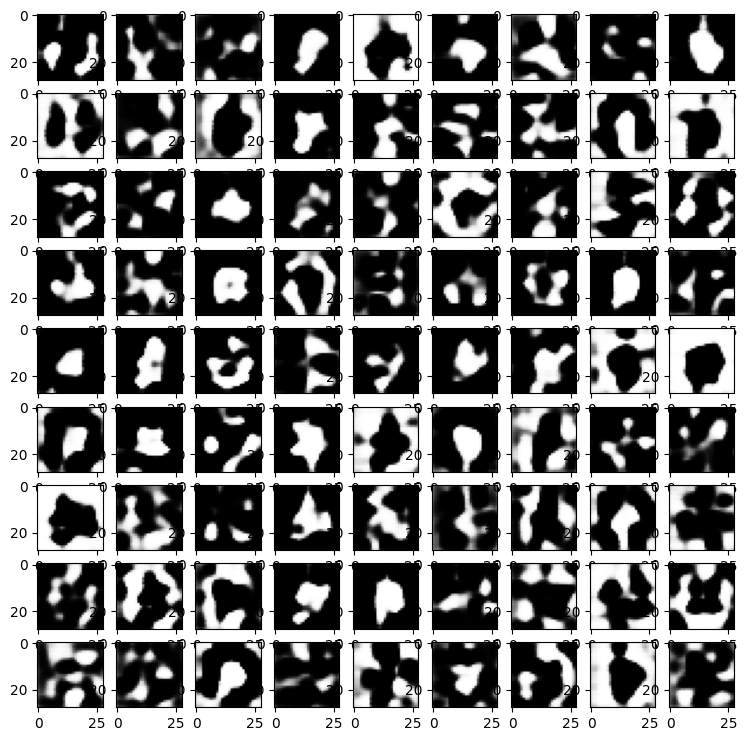

E:1, Loss G0.6755, Loss D:0.5262,Acc G:% 1.1266, Acc D:%96.20
E:2, Loss G0.6813, Loss D:0.5189,Acc G:% 1.0220, Acc D:%96.87


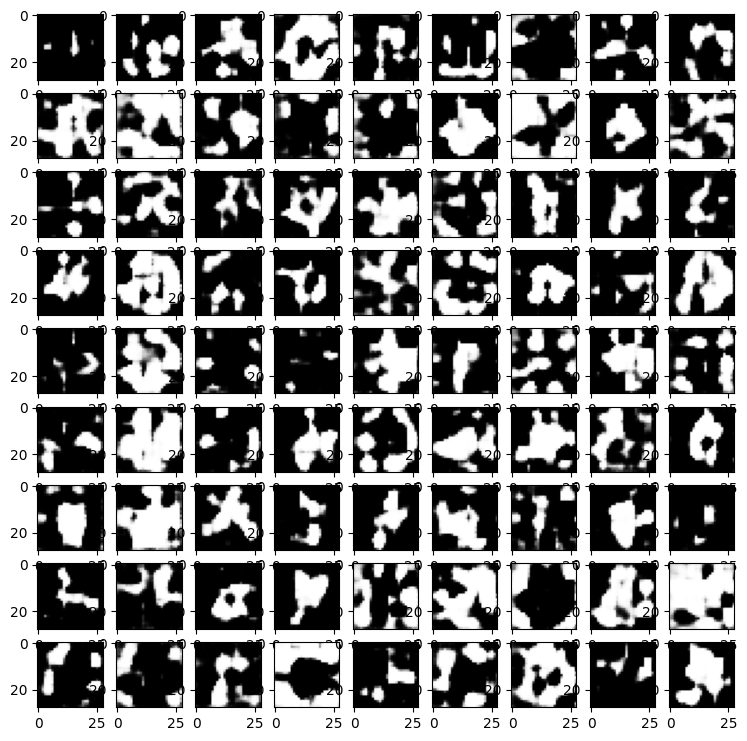

E:3, Loss G0.6847, Loss D:0.5159,Acc G:% 0.9351, Acc D:%97.23
E:4, Loss G0.6926, Loss D:0.5040,Acc G:% 0.7895, Acc D:%97.61


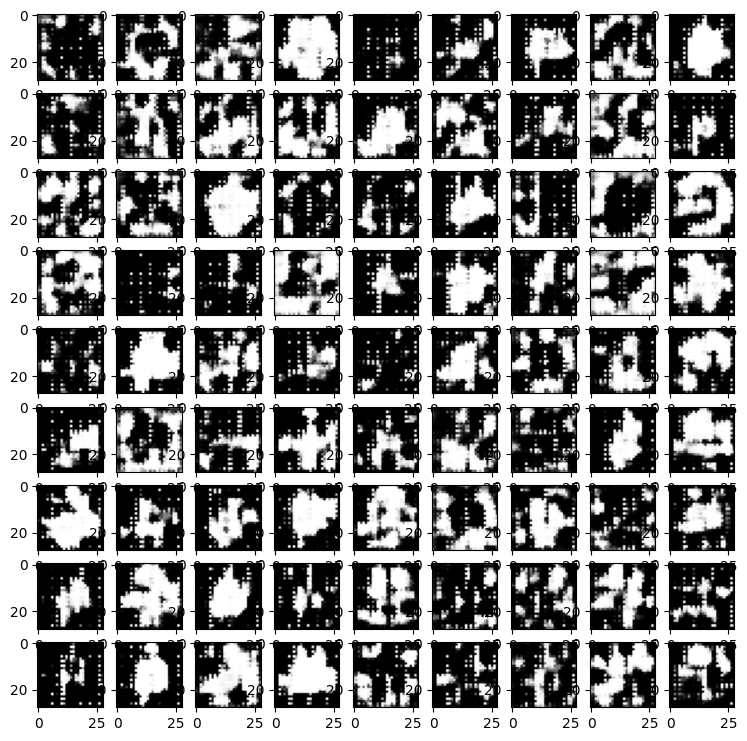

E:5, Loss G0.6912, Loss D:0.5058,Acc G:% 0.6487, Acc D:%98.03
E:6, Loss G0.6878, Loss D:0.5112,Acc G:% 0.6532, Acc D:%98.14


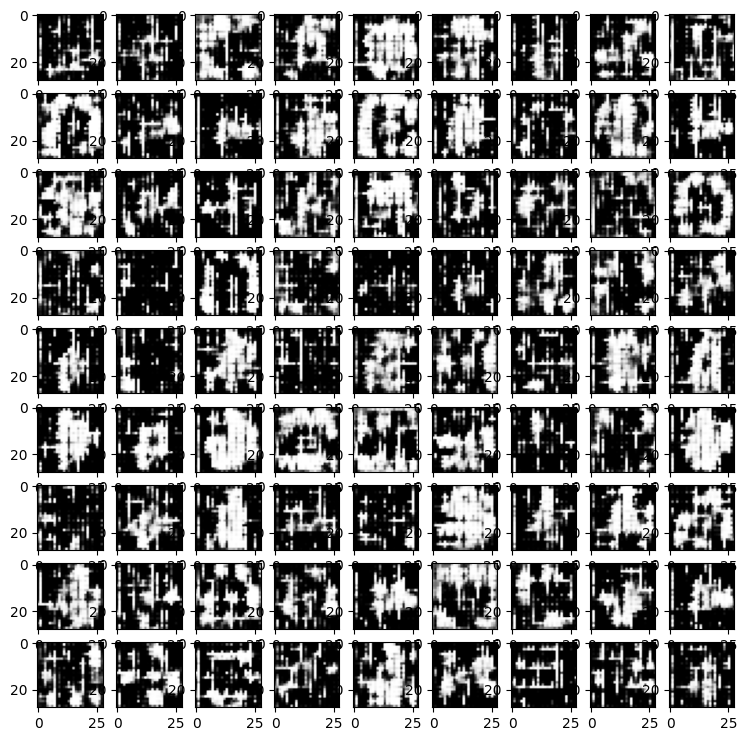

E:7, Loss G0.6895, Loss D:0.5085,Acc G:% 0.6154, Acc D:%98.30
E:8, Loss G0.6668, Loss D:0.5569,Acc G:% 0.8241, Acc D:%97.83


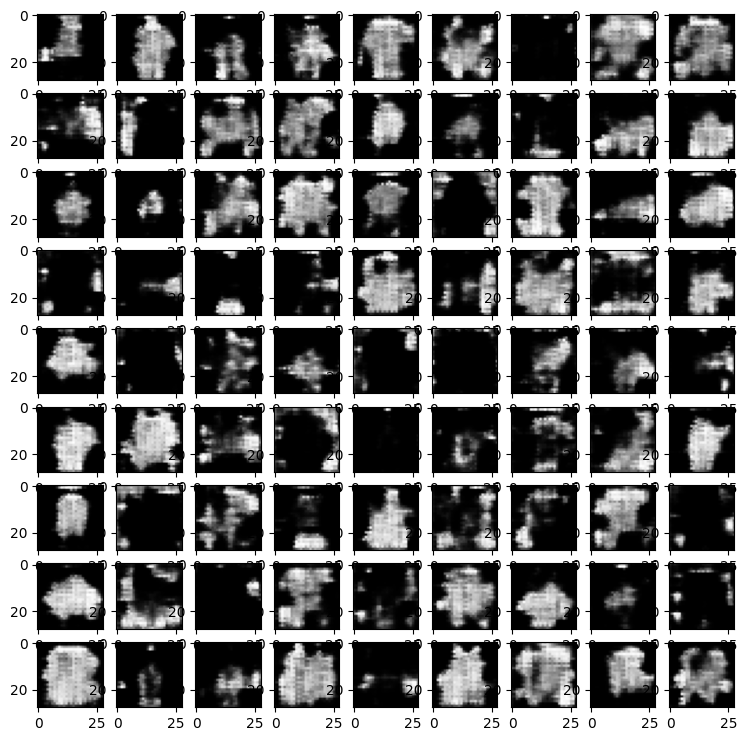

E:9, Loss G0.6372, Loss D:0.6208,Acc G:% 1.4689, Acc D:%96.05
E:10, Loss G0.6375, Loss D:0.6182,Acc G:% 2.3319, Acc D:%93.85


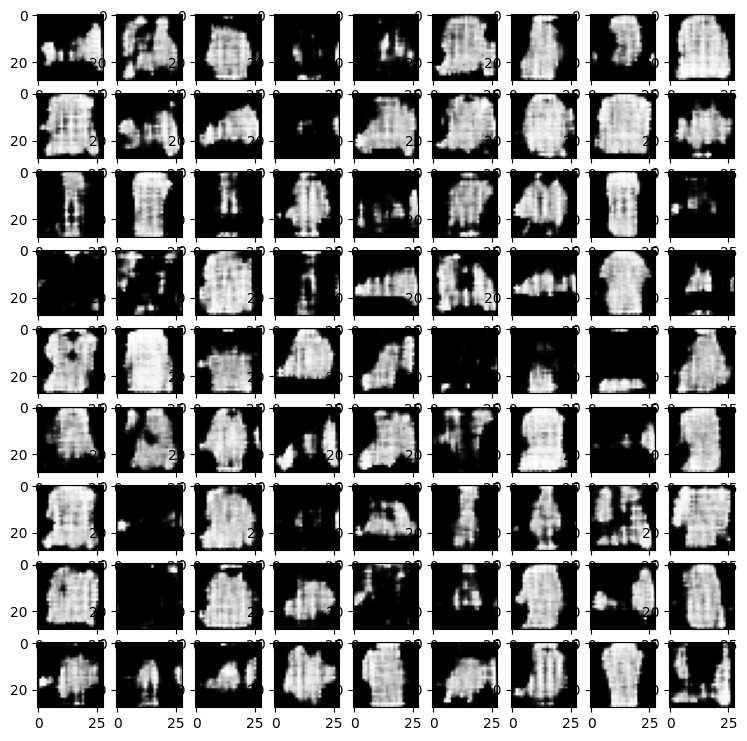

E:11, Loss G0.6384, Loss D:0.6272,Acc G:% 2.8889, Acc D:%91.97
E:12, Loss G0.6370, Loss D:0.6287,Acc G:% 3.2323, Acc D:%90.30


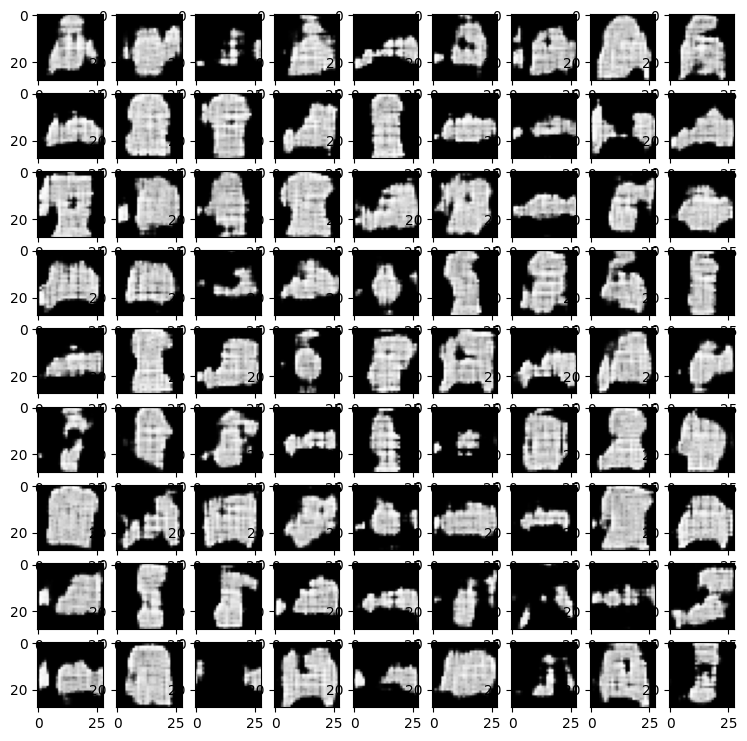

E:13, Loss G0.6382, Loss D:0.6249,Acc G:% 3.4942, Acc D:%88.90
E:14, Loss G0.6363, Loss D:0.6217,Acc G:% 3.6955, Acc D:%87.81


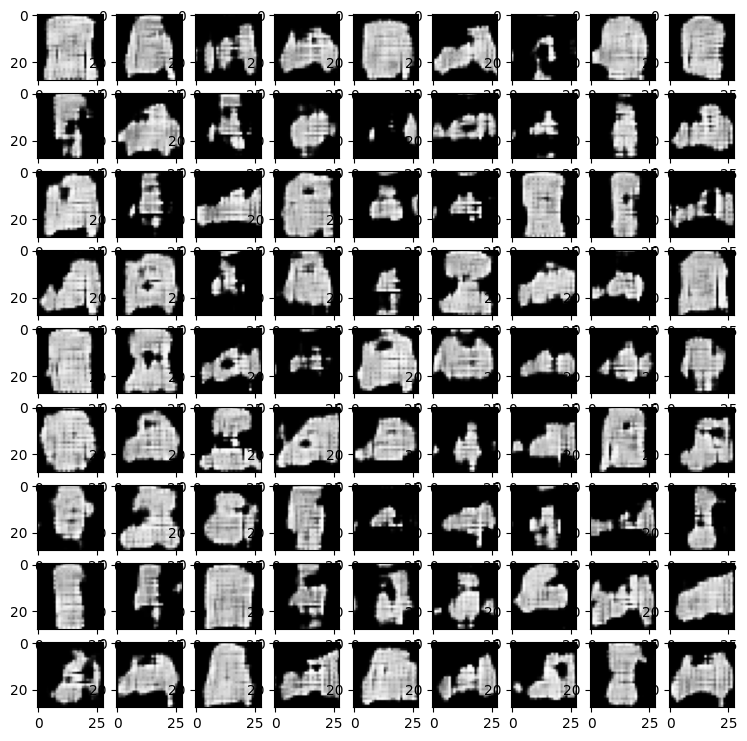

E:15, Loss G0.6338, Loss D:0.6180,Acc G:% 3.8907, Acc D:%86.93
E:16, Loss G0.6348, Loss D:0.6126,Acc G:% 4.0731, Acc D:%86.23


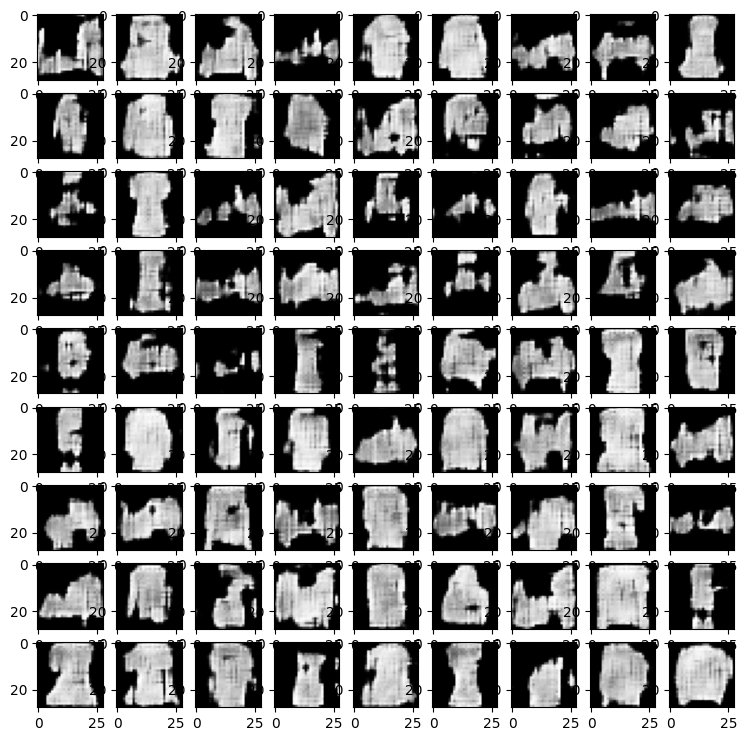

E:17, Loss G0.6392, Loss D:0.6042,Acc G:% 4.1882, Acc D:%85.75
E:18, Loss G0.6417, Loss D:0.6111,Acc G:% 4.2734, Acc D:%85.31


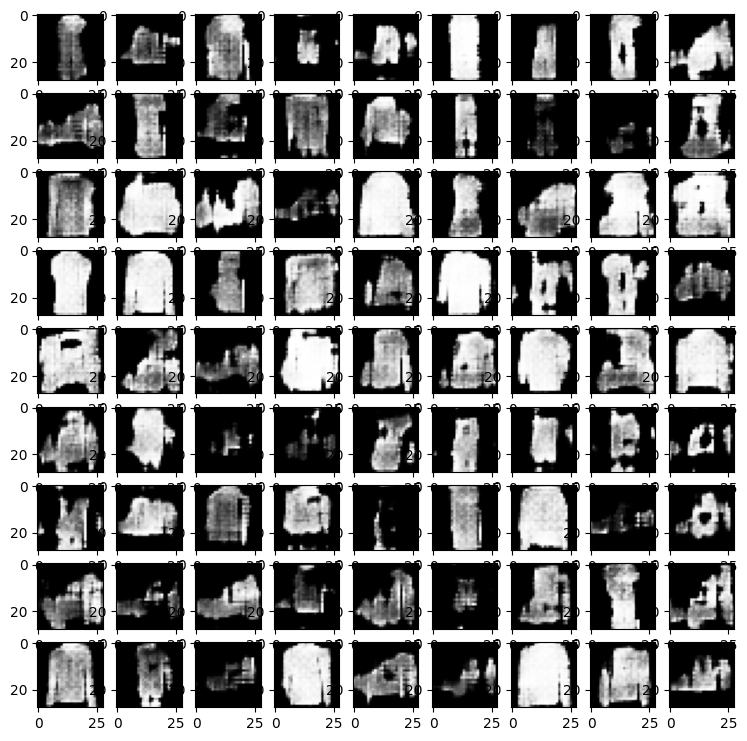

E:19, Loss G0.6431, Loss D:0.6149,Acc G:% 4.3687, Acc D:%84.78


In [7]:
for epoch in range(20):
    dLossSum = 0
    gLossSum = 0
    dAccSum = 0
    gAccSum = 0
    cnt=0
    for batch in dataset:
        dLoss = trainDstep(batch)
        dLossSum += dLoss['discriminator_loss']
        dAccSum += dLoss['discriminator_accuracy']

        gLoss = trainGstep(batch)
        gLossSum += gLoss['generator_loss']
        gAccSum += gLoss['generator_accuracy']

        cnt += 1

    print("E:{}, Loss G{:0.4f}, Loss D:{:0.4f},Acc G:% {:0.4f}, Acc D:%{:0.2f}".format(
    epoch,
    gLossSum/cnt,
    dLossSum/cnt,
    100* gAccSum/cnt,
    100* dAccSum/cnt))

    if epoch % 2 == 0:
        plotImages(generator)


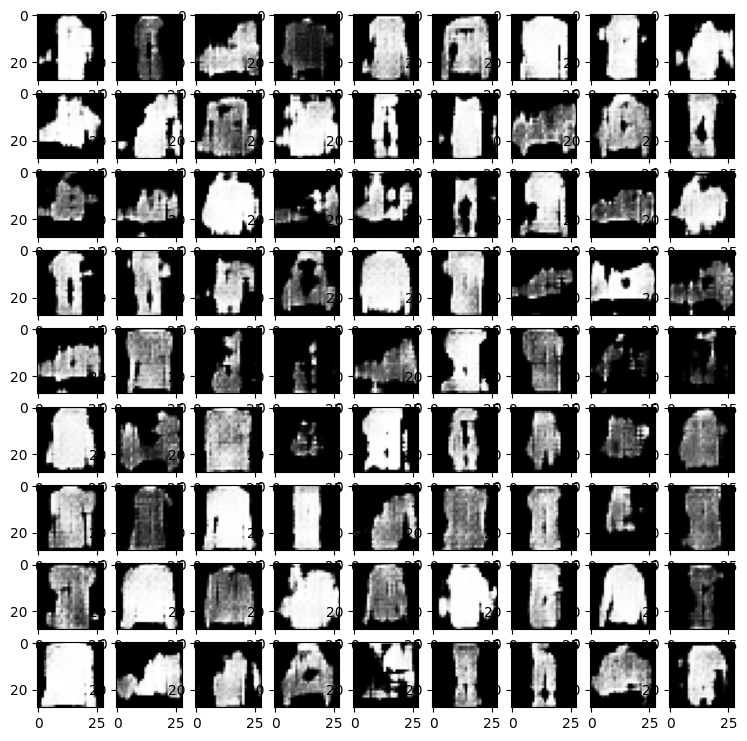

In [8]:
#generating a new fashion_mnist image with trained GAN:
plotImages(generator)